In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_bias_2_models_atmos
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle

In [2]:
# creo un dizionario in cui andrò a mettere tutti i modelli dentro
models_zonavg = {}

In [3]:
#Percorso dei file
name_models_zonavg = '/work/users/guest/sbeltrami/prova/zonal_mean_name_ok_model.txt'
path_models_zonavg = '/work/users/guest/sbeltrami/prova/path_zonal_mean_model.txt'
path_remap_models_zonavg = '/work/users/guest/sbeltrami/prova/path_remap_zonal_mean_model.txt'
path_zonal_model_models_zonavg = '/work/users/guest/sbeltrami/prova/path_zonavg_model.txt'
# Apro i 3 file in modalità di lettura
with open(name_models_zonavg, 'r') as file: #nome file
    # Leggo tutte le righe del file e salvo in una lista
    lines_name_models_zonavg = file.readlines()
with open(path_models_zonavg, 'r') as file: #percorso dei file .nc
    lines_path_models_zonavg = file.readlines()
with open(path_remap_models_zonavg, 'r') as file: #percorso dei file remap
    lines_path_remap_models_zonavg = file.readlines()
with open(path_zonal_model_models_zonavg, 'r') as file: #percorso dei file remap + zonavg
    lines_path_zonal_model_models_zonavg = file.readlines()

In [4]:
# Itero su tutte le righe dei 3 file e organizzo i dati nel dizionario
for line_name, line_path, line_path_remap, line_path_zonal_model in zip(lines_name_models_zonavg, lines_path_models_zonavg, lines_path_remap_models_zonavg,lines_path_zonal_model_models_zonavg): #zip per iterare sulle 3 liste contemporaneamente
    model_name = line_name.strip() #senza spazi bianchi
    #model_name è la chiave principale
    # Inizializzo il dizionario se non esiste ancora
    if model_name not in models_zonavg:
        models_zonavg[model_name] = {}
    # Aggiungo name, path, path remap come sottochiavi
    models_zonavg[model_name]['zonavg name'] = model_name
    models_zonavg[model_name]['zonavg path'] = line_path.strip()
    models_zonavg[model_name]['zonavg path remap'] = line_path_remap.strip()
    models_zonavg[model_name]['zonavg path remap zonal mean'] = line_path_zonal_model.strip()

In [5]:
models_zonavg.items()

dict_items([('TaiESM1', {'zonavg name': 'TaiESM1', 'zonavg path': '/work/users/guest/sbeltrami/zonal_mean/TaiESM1.nc', 'zonavg path remap': '/work/users/guest/sbeltrami/zonal_mean/TaiESM1_remapcon.nc', 'zonavg path remap zonal mean': '/work/users/guest/sbeltrami/zonal_mean/TaiESM1_zonal_mean.nc'}), ('AWI-CM-1-1-MR', {'zonavg name': 'AWI-CM-1-1-MR', 'zonavg path': '/work/users/guest/sbeltrami/zonal_mean/AWI-CM-1-1-MR.nc', 'zonavg path remap': '/work/users/guest/sbeltrami/zonal_mean/AWI-CM-1-1-MR_remapcon.nc', 'zonavg path remap zonal mean': '/work/users/guest/sbeltrami/zonal_mean/AWI-CM-1-1-MR_zonal_mean.nc'}), ('AWI-ESM-1-1-LR', {'zonavg name': 'AWI-ESM-1-1-LR', 'zonavg path': '/work/users/guest/sbeltrami/zonal_mean/AWI-ESM-1-1-LR.nc', 'zonavg path remap': '/work/users/guest/sbeltrami/zonal_mean/AWI-ESM-1-1-LR_remapcon.nc', 'zonavg path remap zonal mean': '/work/users/guest/sbeltrami/zonal_mean/AWI-ESM-1-1-LR_zonal_mean.nc'}), ('BCC-CSM2-MR', {'zonavg name': 'BCC-CSM2-MR', 'zonavg path

In [6]:
for name in models_zonavg.keys():
    path_remap = models_zonavg[name]['zonavg path remap zonal mean'] #remap + zonavg
    if os.path.exists(path_remap): #Se il file esiste
        # Apro il dataset
        models_zonavg[name]['zonavg dataset'] = xr.open_dataset(path_remap)
        dataset = models_zonavg[name]['zonavg dataset']
        #Seleziono il periodo 1982-2014
        models_zonavg[name]['zonavg period 1982 2014'] = dataset['ua'].sel(time=slice("1982-01", "2014-12"))
        dataset_period = models_zonavg[name]['zonavg period 1982 2014']
        #peso il dataset
        models_zonavg[name]['zonavg dataset weighted'] = compute_dataset_weighted(dataset_period)
        #faccio la media nel tempo del dataset nel periodo 1982 - 2014
        models_zonavg[name]['zonavg mean 1982 - 2014'] = models_zonavg[name]['zonavg dataset weighted'].mean(dim='time')
        print(models_zonavg[name]['zonavg name']) 
    else:
        print(f"Errore: Il file {path_remap} non esiste per il modello {name}")

TaiESM1
AWI-CM-1-1-MR
AWI-ESM-1-1-LR
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
FGOALS-g3
CanESM5
CMCC-CM2-SR5
ACCESS-ESM1-5
ACCESS-CM2
E3SM-1-0
EC-Earth3
EC-Earth3-Veg
FIO-ESM-2-0
MPI-ESM-1-2-HAM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
GISS-E2-1-G
GISS-E2-1-G-CC
GISS-E2-1-H
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
NorESM2-LM
NorESM2-MM
GFDL-ESM4
NESM3
SAM0-UNICON
MCM-UA-1-0


Text(0.5, 1.02, 'Zonal Mean')

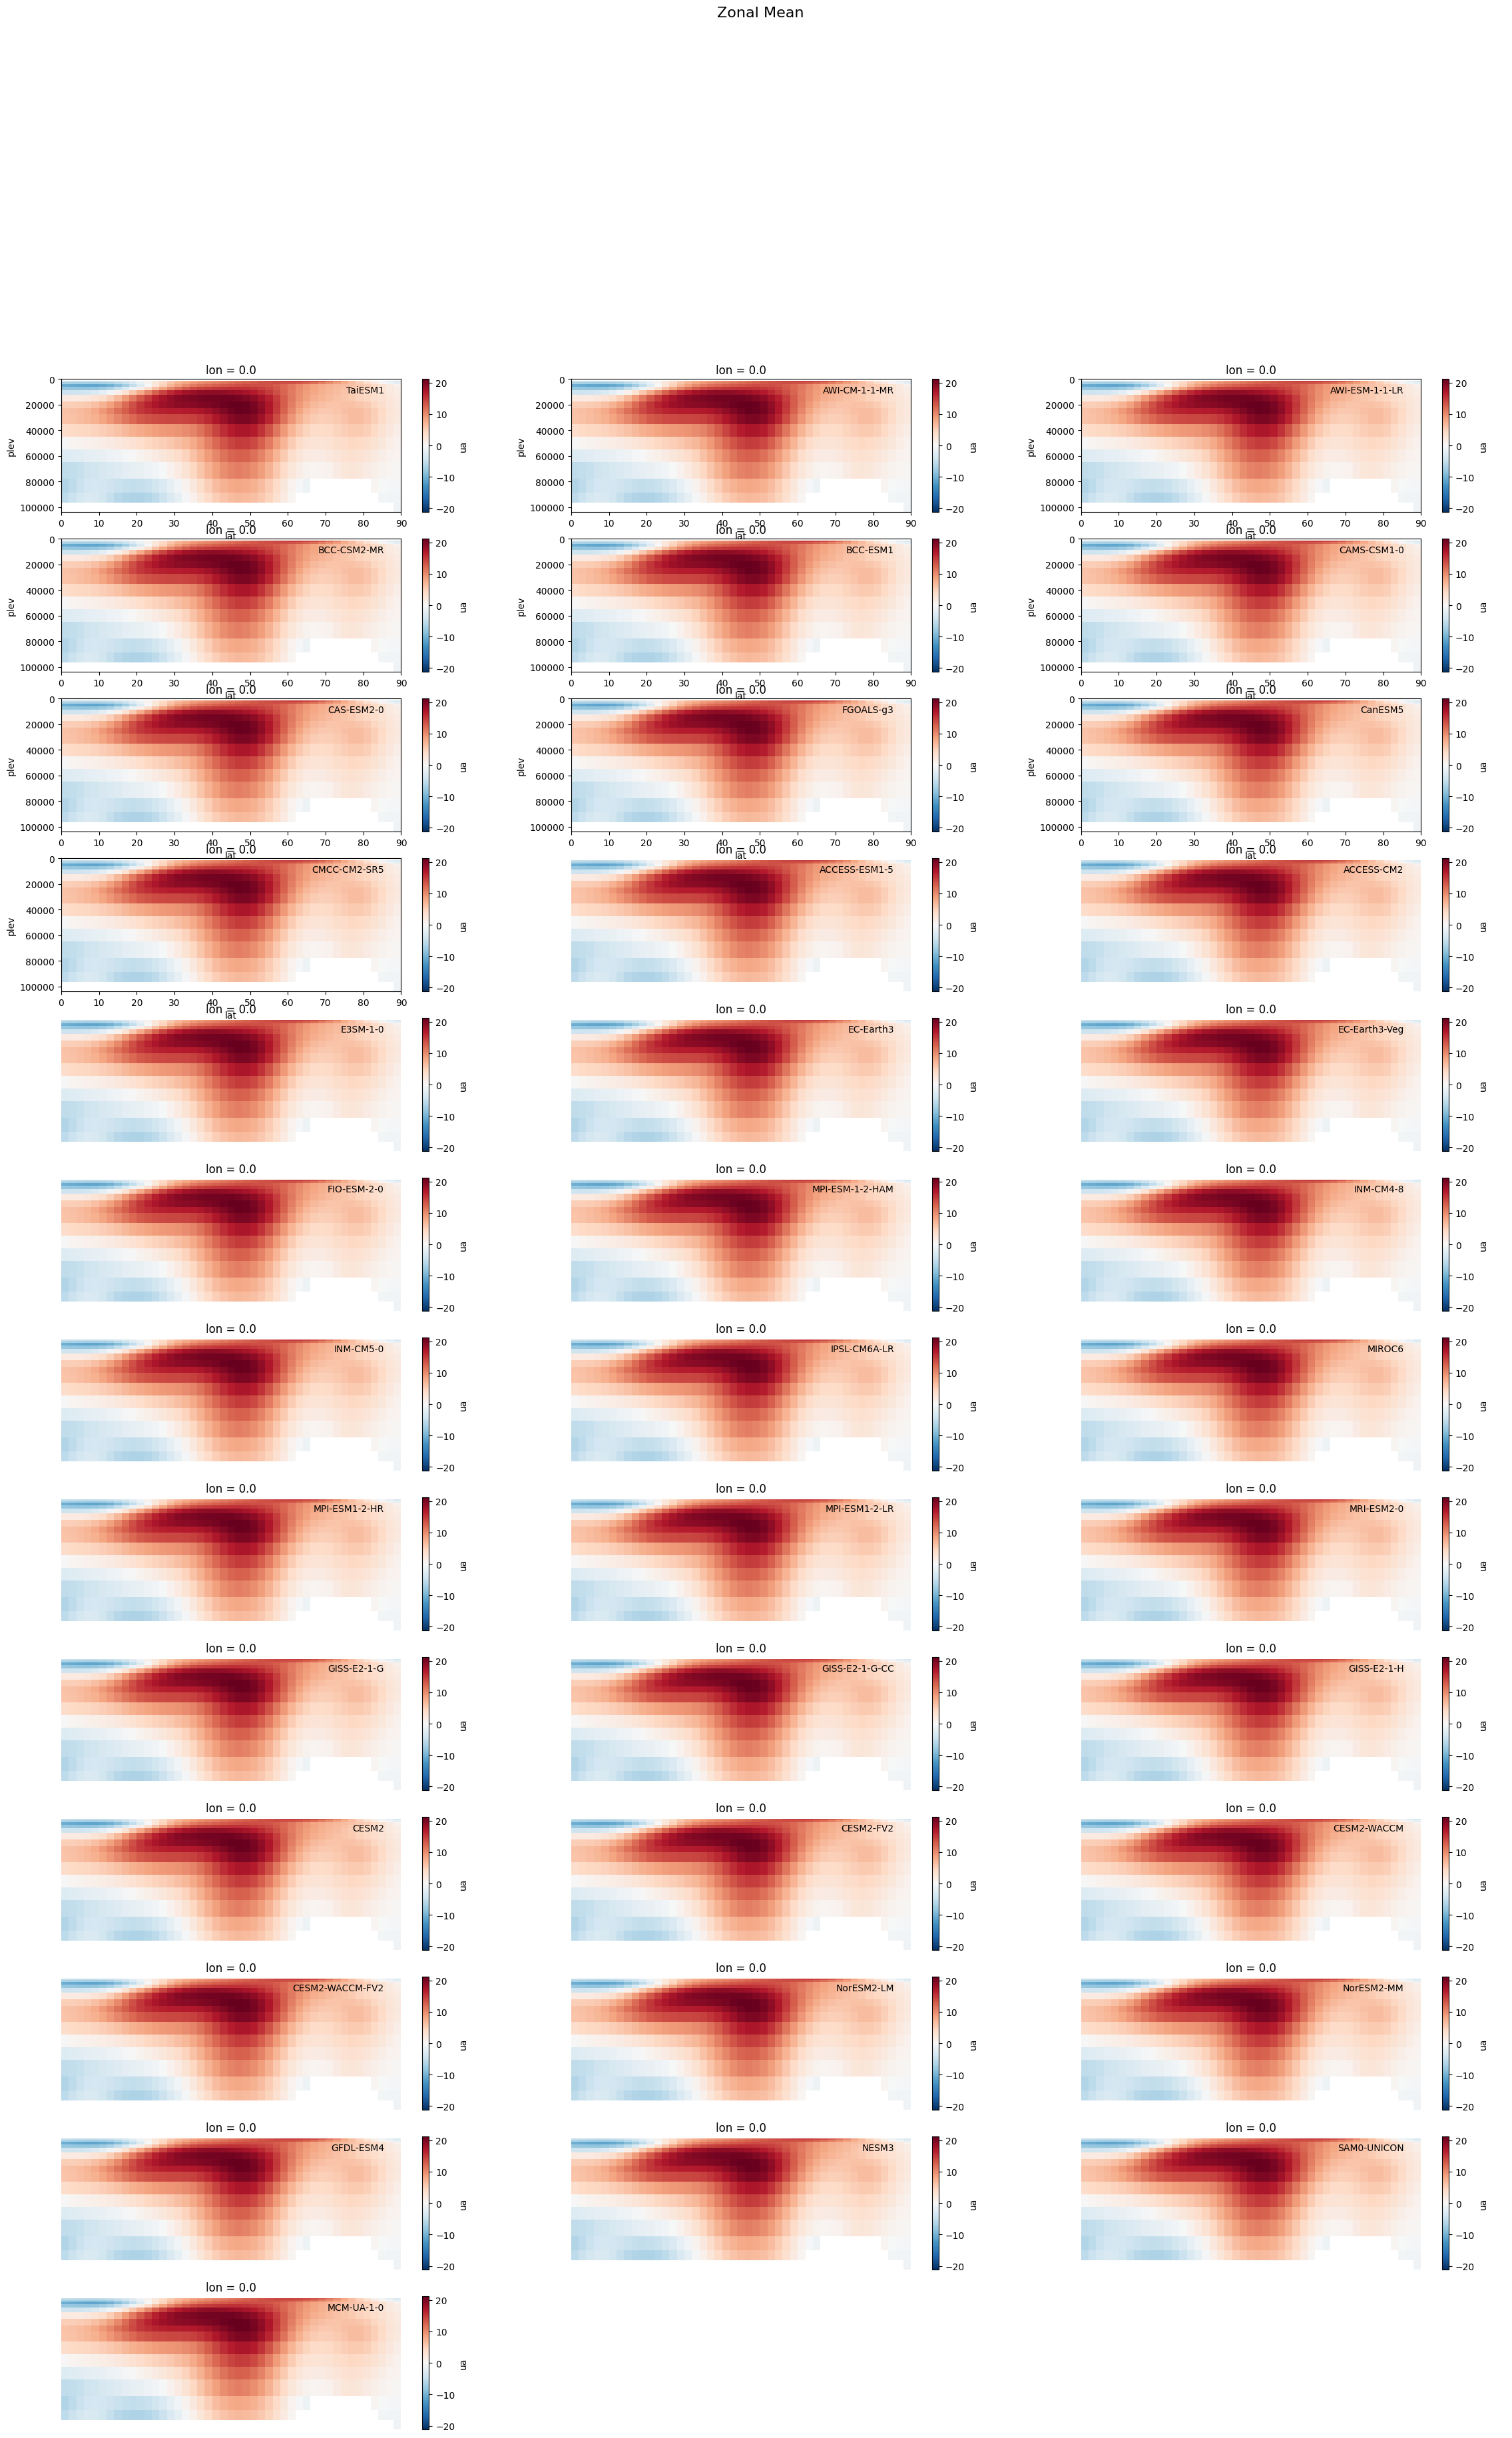

In [9]:
#Creo una lista con il nome dei modelli
models_list_zonavg = list(models_zonavg.keys())
#plot medie annuali dei modelli
fig, ax = plt.subplots(nrows=(int(len(models_zonavg)/3)+1),ncols=3,figsize=(28,40))
# Plot dei modelli
for i in range(int(len(models_zonavg)/3)+1): #ciclo sulle righe
    for j in range(3): #ciclo sulle colonne
        models_index_list = i * 3 + j #indice del modello all'interno della lista
        if models_index_list == len(models_list_zonavg):
            break
        model_name = models_list_zonavg[models_index_list]
        data_array = models_zonavg[name]['zonavg mean 1982 - 2014']
        data_array.plot(ax=ax[i, j])
        ax[i,j].set_ylabel('plev')
        ax[i,j].set_xlabel('lat')
        # Aggiungi il nome del modello in alto a destra
        ax[i,j].text(0.95, 0.95, model_name, horizontalalignment='right', verticalalignment='top', transform=ax[i,j].transAxes, fontsize=10, color='black')
        # Inverto l'asse y in modo t.c i livelli di pressione siano corretti
        ax[i,j].invert_yaxis()

#Rimuovo i quadrati non utilizzati
for i in range(int(len(models_zonavg)/3)+1):
    for j in range(3):
        models_index_list = i * 3 + j
        if models_index_list >= len(model_name):
            ax[i, j].axis('off')

for axes in ax.flat:
    axes.axis("tight")

# Titolo
fig.suptitle('Zonal Mean', fontsize=16, y=1.02)

#plt.savefig('zonal_mean.pdf', format='pdf')